# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

import statsmodels.api as sm
import sklearn

import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [2]:
# Load table
df_numeric = pd.read_csv('../data/df_numeric_with_delays.csv')
print(df_numeric.shape)
df_weather = pd.read_csv('../data/df_weather_aux.csv')
print(df_weather.shape)

(88525, 21)
(83737, 20)


In [3]:
df_numeric.head(3)

,fl_date,origin,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,year,month,day_of_wk
0,2018-10-05,237,248,1655,1655.0,0.0,1825,1806.0,-19.0,150.0,...,764,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,4
1,2018-10-05,304,15,1510,1522.0,12.0,1740,1742.0,2.0,270.0,...,1750,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,4
2,2018-10-05,290,71,1135,1130.0,-5.0,1315,1254.0,-21.0,100.0,...,543,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,4


In [4]:
keys = set(list(df_weather['arr_weather_type']))
values = len(keys)
weather_type_code_map = dict(zip(keys, range(values)))
weather_type_code_map

{'Heavy rain at times': 0,
 'Light showers of ice pellets': 1,
 'Patchy light rain with thunder': 2,
 'Freezing fog': 3,
 'Moderate or heavy snow with thunder': 4,
 'Moderate or heavy freezing rain': 5,
 'Blowing snow': 6,
 'Moderate or heavy sleet': 7,
 'Heavy freezing drizzle': 8,
 'Patchy light snow': 9,
 'Moderate rain at times': 10,
 'Light rain': 11,
 'Sunny': 12,
 'Light drizzle': 13,
 'Heavy snow': 14,
 'Patchy light rain': 15,
 'Overcast': 16,
 'Light freezing rain': 17,
 'Light sleet': 18,
 'Torrential rain shower': 19,
 'Patchy sleet possible': 20,
 'Clear': 21,
 'Light snow': 22,
 'Patchy moderate snow': 23,
 'Partly cloudy': 24,
 'Patchy heavy snow': 25,
 'Moderate rain': 26,
 'Patchy light drizzle': 27,
 'Moderate or heavy rain with thunder': 28,
 'Moderate or heavy snow showers': 29,
 'Light snow showers': 30,
 'Light sleet showers': 31,
 'Moderate snow': 32,
 'Blizzard': 33,
 'Patchy snow possible': 34,
 'Cloudy': 35,
 'Light rain shower': 36,
 'Fog': 37,
 'Patchy light

In [5]:
df_weather['arr_weather_type'] = df_weather['arr_weather_type'].map(weather_type_code_map)
df_weather.head()

,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,arr_pressure,arr_temp_C,arr_time,arr_uv_index,arr_visibility,arr_weather_code,arr_wind_dir_16Point,arr_wind_dir_degree,arr_wind_speed_Kmph,arr_weather_type
0,31,22,27,0.0,11.6,7,26,5,8,2.4,1017,26,1800,1,9,176,SSW,194,2,46
1,25,19,23,0.0,11.6,6,23,9,3,0.0,1012,23,1800,1,10,113,WSW,238,8,21
2,22,15,19,0.0,8.7,5,22,12,6,0.0,1018,22,1200,6,10,113,WNW,288,10,12
3,31,26,29,0.0,11.6,6,27,10,17,0.9,1015,27,0,1,9,176,SE,138,6,46
4,18,7,14,0.0,11.6,4,14,7,19,0.0,1018,13,900,4,10,113,SE,143,6,12


In [6]:
df_numeric = df_numeric.iloc[:83737, :]

In [7]:
# Add the y-variable arr_delay to the weather dataframe:
arr_delay = list(df_numeric['arr_delay'])
arr_delay = arr_delay[:83737]

df_weather['arr_delay'] = arr_delay
df_weather.head()

fl_date = list(df_numeric['fl_date'])
fl_date = fl_date[:83737]

df_weather['fl_date'] = fl_date
df_weather.head()


,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,...,arr_time,arr_uv_index,arr_visibility,arr_weather_code,arr_wind_dir_16Point,arr_wind_dir_degree,arr_wind_speed_Kmph,arr_weather_type,arr_delay,fl_date
0,31,22,27,0.0,11.6,7,26,5,8,2.4,...,1800,1,9,176,SSW,194,2,46,-19.0,2018-10-05
1,25,19,23,0.0,11.6,6,23,9,3,0.0,...,1800,1,10,113,WSW,238,8,21,2.0,2018-10-05
2,22,15,19,0.0,8.7,5,22,12,6,0.0,...,1200,6,10,113,WNW,288,10,12,-21.0,2018-10-05
3,31,26,29,0.0,11.6,6,27,10,17,0.9,...,0,1,9,176,SE,138,6,46,23.0,2018-10-05
4,18,7,14,0.0,11.6,4,14,7,19,0.0,...,900,4,10,113,SE,143,6,12,24.0,2018-10-05


In [8]:
df_weather.drop(columns=['arr_wind_dir_16Point'], index=1, inplace=True)
df_weather.head()

,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,...,arr_temp_C,arr_time,arr_uv_index,arr_visibility,arr_weather_code,arr_wind_dir_degree,arr_wind_speed_Kmph,arr_weather_type,arr_delay,fl_date
0,31,22,27,0.0,11.6,7,26,5,8,2.4,...,26,1800,1,9,176,194,2,46,-19.0,2018-10-05
2,22,15,19,0.0,8.7,5,22,12,6,0.0,...,22,1200,6,10,113,288,10,12,-21.0,2018-10-05
3,31,26,29,0.0,11.6,6,27,10,17,0.9,...,27,0,1,9,176,138,6,46,23.0,2018-10-05
4,18,7,14,0.0,11.6,4,14,7,19,0.0,...,13,900,4,10,113,143,6,12,24.0,2018-10-05
5,20,17,18,0.0,5.7,4,17,19,100,0.1,...,17,900,4,10,122,26,14,16,-10.0,2018-10-05


Drop the cheater-pants variables from flight data:


In [9]:
day_of_delays = [
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'crs_elapsed_time',
    'late_aircraft_delay',
    'dep_delay'
]

df_numeric.drop(columns = day_of_delays, axis = 1, inplace = True)

In [10]:
df_numeric.drop(['fl_date'], axis= 1, inplace= True)
df_numeric.head(3)

,origin,dest,crs_dep_time,dep_time,crs_arr_time,arr_time,arr_delay,air_time,distance,first_dep_time,year,month,day_of_wk
0,237,248,1655,1655.0,1825,1806.0,-19.0,110.0,764,NaN,2018,10,4
1,304,15,1510,1522.0,1740,1742.0,2.0,242.0,1750,NaN,2018,10,4
2,290,71,1135,1130.0,1315,1254.0,-21.0,73.0,543,NaN,2018,10,4


### MERGE

In [11]:
df_fl_weather = pd.merge(df_weather, df_numeric, left_index=True, right_index=True)
print(df_fl_weather.shape)
df_fl_weather.head()

(83736, 34)


,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,...,dep_time,crs_arr_time,arr_time_y,arr_delay_y,air_time,distance,first_dep_time,year,month,day_of_wk
0,31,22,27,0.0,11.6,7,26,5,8,2.4,...,1655.0,1825,1806.0,-19.0,110.0,764,NaN,2018,10,4
2,22,15,19,0.0,8.7,5,22,12,6,0.0,...,1130.0,1315,1254.0,-21.0,73.0,543,NaN,2018,10,4
3,31,26,29,0.0,11.6,6,27,10,17,0.9,...,1854.0,2255,2318.0,23.0,130.0,1020,NaN,2018,10,4
4,18,7,14,0.0,11.6,4,14,7,19,0.0,...,857.0,1015,1039.0,24.0,84.0,601,NaN,2018,10,4
5,20,17,18,0.0,5.7,4,17,19,100,0.1,...,645.0,915,905.0,-10.0,126.0,919,NaN,2018,10,4


>_NOTE: Weather API request for loop was terminated approx. 5K records from completion._

In [12]:
df = df_fl_weather.copy()


Assign the `target` variable `arr_time` to `y`

In [13]:
# Assign target variable
y = df.arr_delay_x

# Then drop it from the table:
df.drop(['arr_delay_x', 'arr_delay_y', 'fl_date'], axis= 1, inplace= True)
df.head()

,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,...,crs_dep_time,dep_time,crs_arr_time,arr_time_y,air_time,distance,first_dep_time,year,month,day_of_wk
0,31,22,27,0.0,11.6,7,26,5,8,2.4,...,1655,1655.0,1825,1806.0,110.0,764,NaN,2018,10,4
2,22,15,19,0.0,8.7,5,22,12,6,0.0,...,1135,1130.0,1315,1254.0,73.0,543,NaN,2018,10,4
3,31,26,29,0.0,11.6,6,27,10,17,0.9,...,1830,1854.0,2255,2318.0,130.0,1020,NaN,2018,10,4
4,18,7,14,0.0,11.6,4,14,7,19,0.0,...,825,857.0,1015,1039.0,84.0,601,NaN,2018,10,4
5,20,17,18,0.0,5.7,4,17,19,100,0.1,...,650,645.0,915,905.0,126.0,919,NaN,2018,10,4


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83736 entries, 0 to 83736
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   max_temp_C           83736 non-null  int64  
 1   min_temp_C           83736 non-null  int64  
 2   avg_temp_C           83736 non-null  int64  
 3   total_snow_cm        83736 non-null  float64
 4   sun_hour             83736 non-null  float64
 5   uv_index             83736 non-null  int64  
 6   arr_wind_chill_C     83736 non-null  int64  
 7   arr_wind_gust_Kmph   83736 non-null  int64  
 8   arr_cloud_cover      83736 non-null  int64  
 9   arr_precip_MM        83736 non-null  float64
 10  arr_pressure         83736 non-null  int64  
 11  arr_temp_C           83736 non-null  int64  
 12  arr_time_x           83736 non-null  int64  
 13  arr_uv_index         83736 non-null  int64  
 14  arr_visibility       83736 non-null  int64  
 15  arr_weather_code     83736 non-null 

In [15]:
df.isna().sum()

max_temp_C                 0
min_temp_C                 0
avg_temp_C                 0
total_snow_cm              0
sun_hour                   0
uv_index                   0
arr_wind_chill_C           0
arr_wind_gust_Kmph         0
arr_cloud_cover            0
arr_precip_MM              0
arr_pressure               0
arr_temp_C                 0
arr_time_x                 0
arr_uv_index               0
arr_visibility             0
arr_weather_code           0
arr_wind_dir_degree        0
arr_wind_speed_Kmph        0
arr_weather_type           0
origin                     0
dest                       0
crs_dep_time               0
dep_time                   0
crs_arr_time               0
arr_time_y                 0
air_time                  35
distance                   0
first_dep_time         83606
year                       0
month                      0
day_of_wk                  0
dtype: int64

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [21]:
df_col_list = sorted(list(df.columns))

In [ ]:
'air_time'
'arr_cloud_cover'
'arr_precip_MM'
'arr_pressure'
'arr_temp_C'
'arr_time_x'
'arr_time_y'
'arr_uv_index'
'arr_visibility'
'arr_weather_code'
'arr_weather_type'
'arr_wind_chill_C'
'arr_wind_dir_degree'
'arr_wind_gust_Kmph'
'arr_wind_speed_Kmph'
'avg_temp_C'
'crs_arr_time'
'crs_dep_time'
'day_of_wk'
'dep_time'
'dest'
'distance'
'first_dep_time'
'max_temp_C'
'min_temp_C'
'month'
'origin'
'sun_hour'
'total_snow_cm'
'uv_index'
'year'

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

##### REMOVING FEATURES WITH SMALL VARIANCE 

Removing columns with little variance which would have small predictive power.


(_Referenced: [W5Em13_Variable_selection](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W5/W5Em13_Variable_selection.ipynb)_)

In [22]:
import sklearn
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.1)
df_transformed = vt.fit_transform(df)

to see how many columns were dropped:

In [23]:
print(df.shape)
print(df_transformed.shape)

(83736, 31)
(83736, 31)


In [24]:
# columns we have selected
# VarianceThreshold get_support() stores boolean of each variable in the np.array.
selected_columns = df.columns[vt.get_support()]
print(selected_columns)

# transforming the np.array back to a DataFrame preserves column labels
df_transformed = pd.DataFrame(df_transformed, columns = selected_columns)
df_transformed.head()

Index(['max_temp_C', 'min_temp_C', 'avg_temp_C', 'total_snow_cm', 'sun_hour',
       'uv_index', 'arr_wind_chill_C', 'arr_wind_gust_Kmph', 'arr_cloud_cover',
       'arr_precip_MM', 'arr_pressure', 'arr_temp_C', 'arr_time_x',
       'arr_uv_index', 'arr_visibility', 'arr_weather_code',
       'arr_wind_dir_degree', 'arr_wind_speed_Kmph', 'arr_weather_type',
       'origin', 'dest', 'crs_dep_time', 'dep_time', 'crs_arr_time',
       'arr_time_y', 'air_time', 'distance', 'first_dep_time', 'year', 'month',
       'day_of_wk'],
      dtype='object')


,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,...,crs_dep_time,dep_time,crs_arr_time,arr_time_y,air_time,distance,first_dep_time,year,month,day_of_wk
0,31.0,22.0,27.0,0.0,11.6,7.0,26.0,5.0,8.0,2.4,...,1655.0,1655.0,1825.0,1806.0,110.0,764.0,NaN,2018.0,10.0,4.0
1,22.0,15.0,19.0,0.0,8.7,5.0,22.0,12.0,6.0,0.0,...,1135.0,1130.0,1315.0,1254.0,73.0,543.0,NaN,2018.0,10.0,4.0
2,31.0,26.0,29.0,0.0,11.6,6.0,27.0,10.0,17.0,0.9,...,1830.0,1854.0,2255.0,2318.0,130.0,1020.0,NaN,2018.0,10.0,4.0
3,18.0,7.0,14.0,0.0,11.6,4.0,14.0,7.0,19.0,0.0,...,825.0,857.0,1015.0,1039.0,84.0,601.0,NaN,2018.0,10.0,4.0
4,20.0,17.0,18.0,0.0,5.7,4.0,17.0,19.0,100.0,0.1,...,650.0,645.0,915.0,905.0,126.0,919.0,NaN,2018.0,10.0,4.0


##### REMOVING CORRELATED FEATURES:

In [25]:
# STEP 1: Correlation matrix
df_corr = df_transformed.corr().abs()

Using `0.8` as the correlation threshold:

In [26]:
# STEP 2: find pairs of highly correlated features
indices = np.where(df_corr > 0.8) 
indices = [(df_corr.index[x], df_corr.columns[y]) 
   for x, y in zip(*indices)
      if x != y and x < y]

Using try-except logic to allows the code to continue in the event a `KeyError` occurs because a high correlation occurred more than once with the same feature.

In [27]:
# STEP 3: Removing the highly correlated columns
for idx in indices: #each pair
    try:
        df_transformed.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [28]:
# The correlated paris are:
indices

[('max_temp_C', 'min_temp_C'),
 ('max_temp_C', 'avg_temp_C'),
 ('max_temp_C', 'uv_index'),
 ('max_temp_C', 'arr_wind_chill_C'),
 ('max_temp_C', 'arr_temp_C'),
 ('min_temp_C', 'avg_temp_C'),
 ('min_temp_C', 'uv_index'),
 ('min_temp_C', 'arr_wind_chill_C'),
 ('min_temp_C', 'arr_temp_C'),
 ('avg_temp_C', 'uv_index'),
 ('avg_temp_C', 'arr_wind_chill_C'),
 ('avg_temp_C', 'arr_temp_C'),
 ('uv_index', 'arr_wind_chill_C'),
 ('uv_index', 'arr_temp_C'),
 ('arr_wind_chill_C', 'arr_temp_C'),
 ('arr_wind_gust_Kmph', 'arr_wind_speed_Kmph'),
 ('crs_dep_time', 'dep_time'),
 ('crs_dep_time', 'first_dep_time'),
 ('dep_time', 'first_dep_time'),
 ('crs_arr_time', 'arr_time_y'),
 ('air_time', 'distance')]

In [29]:
# Recheck shape of table:
print(df_transformed.shape)
df_transformed.head()

(83736, 21)


,max_temp_C,total_snow_cm,sun_hour,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,arr_pressure,arr_time_x,arr_uv_index,arr_visibility,...,arr_wind_dir_degree,arr_weather_type,origin,dest,crs_dep_time,crs_arr_time,air_time,year,month,day_of_wk
0,31.0,0.0,11.6,5.0,8.0,2.4,1017.0,1800.0,1.0,9.0,...,194.0,46.0,237.0,248.0,1655.0,1825.0,110.0,2018.0,10.0,4.0
1,22.0,0.0,8.7,12.0,6.0,0.0,1018.0,1200.0,6.0,10.0,...,288.0,12.0,290.0,71.0,1135.0,1315.0,73.0,2018.0,10.0,4.0
2,31.0,0.0,11.6,10.0,17.0,0.9,1015.0,0.0,1.0,9.0,...,138.0,46.0,329.0,34.0,1830.0,2255.0,130.0,2018.0,10.0,4.0
3,18.0,0.0,11.6,7.0,19.0,0.0,1018.0,900.0,4.0,10.0,...,143.0,12.0,329.0,152.0,825.0,1015.0,84.0,2018.0,10.0,4.0
4,20.0,0.0,5.7,19.0,100.0,0.1,1020.0,900.0,4.0,10.0,...,26.0,16.0,137.0,19.0,650.0,915.0,126.0,2018.0,10.0,4.0


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### LINEAR REGRESSION

(_Referenced: [W3D3L Statistical Modeling Demo](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W3/W3D3L-Statistical_Modeling_Demo.ipynb)_)

 With `arr_delay` as our dependent variable ($y$) and `_____` and `_______` as our independent variables ($x_1$ and $x_2$). This multiple linear regression model uses the relationship:

$$
y=b_0 + b_1x_1 + b_2x_2
$$

> Note that if we want an intercept ($b_0$) in a `statsmodels OLS` model, we need to use the statsmodels's `add_constant` function, prior to fitting the model.

In [45]:
# Adds a column of 1's so the model will contain an intercept
X = df.copy()
X = sm.add_constant(X) 
X.head()

,const,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,...,crs_dep_time,dep_time,crs_arr_time,arr_time_y,air_time,distance,first_dep_time,year,month,day_of_wk
0,1.0,31,22,27,0.0,11.6,7,26,5,8,...,1655,1655.0,1825,1806.0,110.0,764,NaN,2018,10,4
2,1.0,22,15,19,0.0,8.7,5,22,12,6,...,1135,1130.0,1315,1254.0,73.0,543,NaN,2018,10,4
3,1.0,31,26,29,0.0,11.6,6,27,10,17,...,1830,1854.0,2255,2318.0,130.0,1020,NaN,2018,10,4
4,1.0,18,7,14,0.0,11.6,4,14,7,19,...,825,857.0,1015,1039.0,84.0,601,NaN,2018,10,4
5,1.0,20,17,18,0.0,5.7,4,17,19,100,...,650,645.0,915,905.0,126.0,919,NaN,2018,10,4


In [46]:
X = X[['const',
 'min_temp_C',
 'sun_hour',
 'arr_cloud_cover',
 'arr_pressure',
 'origin',
 'crs_dep_time',
 'dep_time',
 'crs_arr_time',
 'arr_time_y',
 'air_time',
 'distance',
 'first_dep_time',
 'year',
 'month',
 'day_of_wk']]

In [47]:
X = X.fillna(0)

In [48]:
# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     503.4
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:36:49   Log-Likelihood:            -3.4200e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83720   BIC:                         6.842e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1721.8716    204.757     

Large P>|t| values can be dropped and re-test:

In [33]:
X.drop(columns=['uv_index', 'arr_wind_chill_C'], axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     260.9
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:04:49   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83706   BIC:                         6.843e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1732.8654    

In [34]:
X.drop(columns=['arr_temp_C', 'arr_wind_gust_Kmph'], axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     280.2
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:05:43   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83708   BIC:                         6.843e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1727.8566    

In [35]:
X.drop('arr_uv_index', axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     291.0
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:06:46   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83709   BIC:                         6.843e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1727.4770    

In [36]:
X.drop('arr_visibility', axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     302.7
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:08:03   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83710   BIC:                         6.843e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1725.5422    

In [37]:
X.drop('arr_weather_code', axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     315.3
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:08:44   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83711   BIC:                         6.843e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1725.6712    

In [38]:
X.drop('arr_wind_dir_degree', axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     329.0
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:09:30   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83712   BIC:                         6.842e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1725.1229    

In [41]:
X.drop(columns=['arr_time_x', 'total_snow_cm', 'avg_temp_C', 'max_temp_C'], axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     398.0
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:32:29   Log-Likelihood:            -3.4199e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83716   BIC:                         6.842e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1731.1482    

In [42]:
X.drop(columns=['dest', 'arr_weather_type', 'arr_wind_speed_Kmph', 'arr_precip_MM'], axis=1, inplace=True)

# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            arr_delay_x   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     503.4
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        20:33:25   Log-Likelihood:            -3.4200e+05
No. Observations:               83736   AIC:                         6.840e+05
Df Residuals:                   83720   BIC:                         6.842e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1721.8716    204.757     

In [44]:
list(X.columns)

['const',
 'min_temp_C',
 'sun_hour',
 'arr_cloud_cover',
 'arr_pressure',
 'origin',
 'crs_dep_time',
 'dep_time',
 'crs_arr_time',
 'arr_time_y',
 'air_time',
 'distance',
 'first_dep_time',
 'year',
 'month',
 'day_of_wk']

In [50]:
# Import our model:
from sklearn.linear_model import LinearRegression

Initialize the object and fit the model on our data:

In [51]:
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [52]:
# Check the beta coeffient:
print(regressor.coef_)

[ 0.00000000e+00 -1.50259894e-02  1.43083346e-01  8.06119167e-03
  1.71914265e-02  2.94607142e-03 -3.07723340e-02  3.39727516e-02
 -1.29862328e-03  7.88415743e-04  2.66635410e-01 -3.18041727e-02
  1.69225312e-02 -8.69853872e-01  1.58998372e-01 -2.67421659e-02]


### XGBOOST


_(Referenced: [W6D5m15_Using_XGBoost](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W6/W6D5m15_using_XGBoost.ipynb))_

In [53]:
# Generate Dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)


Using `train_test_split` to create the test and train for cross-validation.
- `test_size` size = 20% 
- `random_state` used for reproducibility

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Instantiating a XGBoost regressor:

In [55]:
xg_reg = xgb.XGBRegressor(
        objective ='reg:squarederror' # Loss function
      , colsample_bytree = 0.3  # % of features used per tree
      , learning_rate = 0.1  # Overfit prevention step size. Range[0,1]
      , max_depth = 5 # Boosting round tree depth
      , alpha = 10  # L1 regularization on leaf weights.
      , n_estimators = 10 # Number of trees to build
)

>Above code was `reg:linear` from class tutorial, but was changed as result of this warning:
>```
>reg:linear is now deprecated in favor of reg:squarederror.
>```

In [56]:
# Fit the training set with .fit():
xg_reg.fit(X_train,y_train)

# Make predictions with .predict():
preds = xg_reg.predict(X_test)

In [57]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 15.006659


In [58]:
# Hyper-parameter dictionary
params = {
      "objective":"reg:squarederror"
    , 'colsample_bytree': 0.3
    , 'learning_rate': 0.1
    , 'max_depth': 5
    , 'alpha': 10
}

# 3-fold cross validation model:
cv_results = xgb.cv(
      dtrain = data_dmatrix
    , params = params
    , nfold = 3
    , num_boost_round = 50
    , early_stopping_rounds = 10
    , metrics = "rmse"
    , as_pandas = True
    , seed = 123
)


>Above code was `reg:linear` from class tutorial, but was changed as result of this warning:
>```
>reg:linear is now deprecated in favor of reg:squarederror.
>```

In [59]:
# Train and test RMSE metrics for each boosting round.
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,15.985252,0.029323,15.992394,0.030784
1,15.752147,0.024627,15.764226,0.035707
2,15.564786,0.020320,15.581828,0.039503
3,15.404491,0.014943,15.425840,0.041790
4,15.275286,0.010887,15.301372,0.043772


In [60]:
print((cv_results["test-rmse-mean"]).tail(1))

49    14.319075
Name: test-rmse-mean, dtype: float64


In [61]:
xg_reg = xgb.train(
      params = params
    , dtrain = data_dmatrix
    , num_boost_round = 10
)

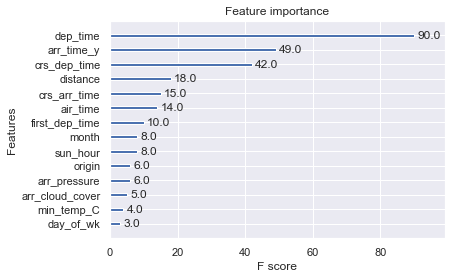

In [62]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

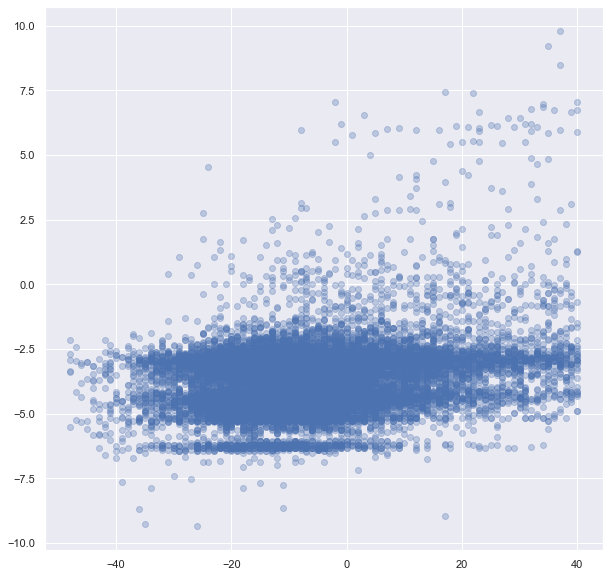

In [63]:
fig = plt.scatter(x= y_test, y= preds, alpha=0.3)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

_(Referenced: [W6D4m9_Model_evaluation](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W6/W6D4m9_model_evaluation.ipynb))_

In [64]:
# import MSE from sklearn
from sklearn.metrics import mean_squared_error

# compute MSE
MSE = mean_squared_error(y_test, preds)  

# print MSE
print(MSE)

225.19982430936292


======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.